In [134]:
import pandas as pd
import billboard as bd #to access this data: https://www.billboard.com/charts/r-b-hip-hop-songs
import pickle
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def create_chart(chart, date):
    '''Produces chart for given date and type in pandas dataframe form with all attributes'''
   # hot100 = bd.ChartData(chart_type, date)
    artists = [x.artist for x in chart]
    titles = [x.title for x in chart]
    peak = [x.peakPos for x in chart]
    last = [x.lastPos for x in chart]
    weeks = [x.weeks for x in chart]
    rank = [x.rank for x in chart]
    isNew = [x.isNew for x in chart]
    billB100 = pd.DataFrame({'Date': date,'Artist':artists, 'Title': titles, 'Peak_Pos': peak, 
                             'Last_Week_Pos': last, 'Rank': rank, 'isNew': isNew })
    return billB100

In [22]:
root_chart= bd.ChartData('r-b-hip-hop-songs', '2019-05-11')

counter = 0
chartList = []
while root_chart.previousDate:
        chartList.append(create_chart(root_chart, root_chart.date))
        root_chart = bd.ChartData('r-b-hip-hop-songs', root_chart.previousDate)
        counter += 1
        if(counter == 520): #get last 52 weeks * #years
            break
full = pd.concat(chartList)

In [117]:
fullDF = full.reset_index()
fullDF.to_pickle("R&B10yrDF.pkl")

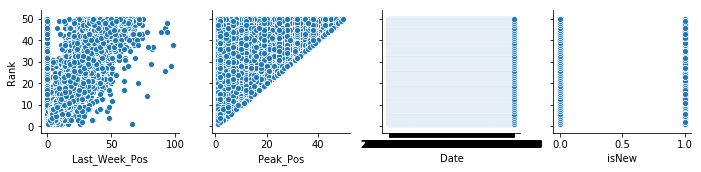

In [121]:
#now can read in data from here
fullDF = pd.read_pickle("R&B10yrDF.pkl")
del fullDF['index']
sns.pairplot(fullDF, x_vars = ['Last_Week_Pos', 'Peak_Pos', 'Date', 'isNew'], y_vars = 'Rank')

Here I will attempt to train a linear regression model that will help predict future song ranks. 

In [91]:
#break training data into 2009-2016 (7 years) and test data into 2016-2019 (3 years)
training = fullDF[(fullDF.Date > '2009-06-06') & (fullDF.Date < '2016-05-22')].drop(columns = ['Artist', 'Title', 'Date'], axis = 1) #credit to this source: https://stackoverflow.com/questions/22898824/filtering-pandas-dataframes-on-dates
testing = fullDF[fullDF.Date > '2016-05-22'].drop(columns = ['Artist', 'Title', 'Date'], axis = 1)
# scaler =  StandardScaler()
# scaler.fit(training)
# training = pd.DataFrame(scaler.transform(training), columns = ['Last_Week_Pos', 'Peak_Pos', 'Rank', 'isNew'])
# scaler.fit(testing)
# testing = pd.DataFrame(scaler.transform(testing), columns = ['Last_Week_Pos', 'Peak_Pos', 'Rank', 'isNew'])
training_x = training.drop('Rank', axis = 1)
training_y = training.Rank
testing_x = testing.drop('Rank', axis = 1)
testing_y = testing.Rank

In [133]:
LR = LinearRegression()
LR.fit(training_x, training_y)
print(LR.coef_)
predicted_ranks = LR.predict(training_x)
training_mse = mean_squared_error(predicted_ranks, training_y)
print("Training MSE: ", training_mse)
predicted_ranks_y = LR.predict(testing_x)
testing_mse = mean_squared_error(predicted_ranks_y, testing_y )
print("Test MSE: ", testing_mse)
LR.score(testing_x, testing_y)

[  0.65070296   0.27875421  22.01406947]
Training MSE:  46.9171531806
Test MSE:  78.5618551236


0.62275219628528

In [132]:
pr = pd.Series(predicted_ranks_y)
ty = pd.Series(testing_y)
pd.DataFrame(pr, ty) #linear regression did a HORRIBLE job

,0
Rank,
1,5.629015
2,6.279718
3,7.766683
4,7.859878
5,9.161284
6,8.231827
7,10.648249
8,12.600358
9,13.343426
